## Credit Card Data Analysis

Analysis of credit card fraud data as a form of anomaly detection. We want to find a model that is good at detecting credit card fraud, here we explore our data set and try XGBoost as a supervised learning method of detecting anomalous data. Not included in final vignette. 

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
credit = pd.read_csv("C:/Users/Keon School/Downloads/credit_card_data/credit_card_transactions.csv")

### Exploratory Data Analysis

In [7]:
credit.head()
# print(credit.shape) ~ 1.3 million rows, 24 columns

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [8]:
# print(credit['is_fraud'].value_counts()) 7506 fraudulent vs. 1,289,169 not fraudulent

In [9]:
#print(credit.isna().sum()) 195973 missing values in merchant zipcode (not a relevant column), no other missing values
# print(credit.info()) columns seem to be properly defined
credit.drop(columns=['trans_date_trans_time', 'cc_num', 'merch_zipcode', 'Unnamed: 0', 'first', 'last', 'street', 'zip', 'lat', 'long', 'trans_num', 'merch_lat', 'merch_long', 'unix_time', 'dob'], 
        inplace=True, axis=1)

In [10]:
credit.head()

,merchant,category,amt,gender,city,state,city_pop,job,is_fraud
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,3495,"Psychologist, counselling",0
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,149,Special educational needs teacher,0
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,4154,Nature conservation officer,0
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,1939,Patent attorney,0
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,99,Dance movement psychotherapist,0


In [11]:
# Exploring fraudulent transactions
fraudulent_trans = credit[credit["is_fraud"] == 1]
fraud_cat_counts = fraudulent_trans['category'].value_counts()
#fraud_cat_counts

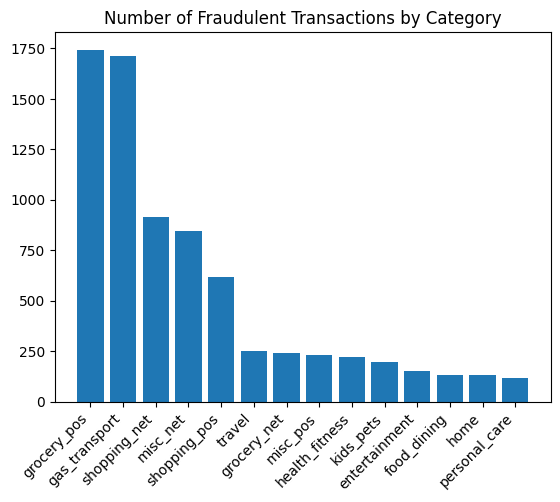

In [12]:
plt.bar(fraudulent_trans['category'].unique(), fraud_cat_counts)
plt.title("Number of Fraudulent Transactions by Category")
plt.xticks(rotation = 45, ha = 'right')
plt.show()

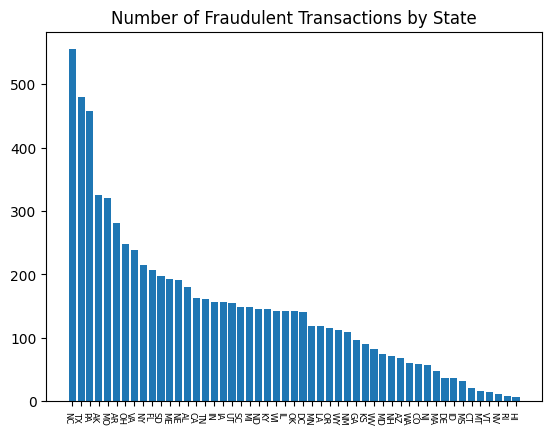

In [13]:
# Fraud by state

fraud_state_counts = fraudulent_trans['state'].value_counts()
plt.bar(fraudulent_trans['state'].unique(), fraud_state_counts)
plt.title("Number of Fraudulent Transactions by State")
plt.xticks(rotation = 270, fontsize = 6, ha = 'right')
plt.show()
# NC, TX, and PA have higher numbers of fraudulent transactions

### Model Building

In [14]:
#!pip install xgboost
import xgboost as xgb

#credit.info()

In [15]:
#categorical_columns = ['merchant', 'category', 'gender', 'city', 'state', 'job', 'is_fraud']

#credit_adj = pd.get_dummies(credit, columns=categorical_columns, drop_first=True)

credit["merchant"] = credit["merchant"].astype("category")
credit["category"] = credit["category"].astype("category")
credit["gender"] = credit["gender"].astype("category")
credit["city"] = credit["city"].astype("category")
credit["state"] = credit["state"].astype("category")
credit["job"] = credit["job"].astype("category")
credit["is_fraud"] = credit["is_fraud"].astype("category")

credit.info()

X = credit.drop(columns=['is_fraud'])
y = credit['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=565)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype   
---  ------    --------------    -----   
 0   merchant  1296675 non-null  category
 1   category  1296675 non-null  category
 2   amt       1296675 non-null  float64 
 3   gender    1296675 non-null  category
 4   city      1296675 non-null  category
 5   state     1296675 non-null  category
 6   city_pop  1296675 non-null  int64   
 7   job       1296675 non-null  category
 8   is_fraud  1296675 non-null  category
dtypes: category(7), float64(1), int64(1)
memory usage: 32.2 MB


In [16]:
model = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True, random_state= 565)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=565, ...)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Accuracy: 0.9967879383808588
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257770
           1       0.80      0.62      0.70      1565

    accuracy                           1.00    259335
   macro avg       0.90      0.81      0.85    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.9926


The accuracy is so high here because of the class imbalance, we have a recall (true positive rate) of 0.62 though, which is still a good start. We will redo the analysis after adjusting for the class imbalance of fraud rate

In [18]:
fraud_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model2 = xgb.XGBClassifier(objective='binary:logistic', enable_categorical=True, random_state= 565, 
                          scale_pos_weight=fraud_weight)

# Train the model
model2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=565, ...)

In [19]:
# New metrics

y_pred2 = model2.predict(X_test)
y_pred_proba2 = model2.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy2)

print(classification_report(y_test, y_pred2))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba2):.4f}")

Accuracy: 0.9960822873888985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257770
           1       0.66      0.73      0.69      1565

    accuracy                           1.00    259335
   macro avg       0.83      0.86      0.85    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC: 0.9842


ROC AUC went down slightly, but metrics overall indicate that the model is doing a good job predicting positive fraud values as well as negative. Let's look at a confusion matrix to further investigate.

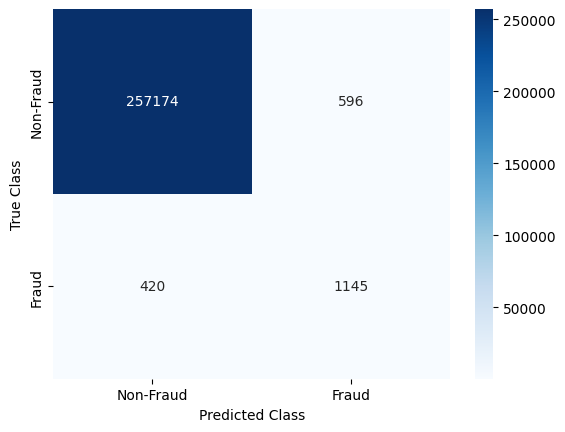

In [20]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

We still do a good job on true fraud data, but 98% ROC doesn't tell the whole story, as it is biased by the large amound of true predicted negatives. We'll just ignore this metric in the rest of the analysis, focusing on precision and recall, which are 0.66 and 0.73 now. Next, we'll proceed with hyperparameter tuning. 

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=565, 
                                enable_categorical = True),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
)

# Fit the grid search
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.878 total time=   6.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.921 total time=   6.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.914 total time=   6.3s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.951 total time=  11.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.968 total time=   8.7s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.943 total time=   6.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.969 total time=   9.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.972 total time=   9.3s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.966 total time=   9.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.94

In [22]:
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]


accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Accuracy:", accuracy_tuned)

print(classification_report(y_test, y_pred_tuned))
print(f"ROC AUC (tuned): {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

Accuracy: 0.9968264985443538
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257770
           1       0.80      0.63      0.71      1565

    accuracy                           1.00    259335
   macro avg       0.90      0.82      0.85    259335
weighted avg       1.00      1.00      1.00    259335

ROC AUC (tuned): 0.9948


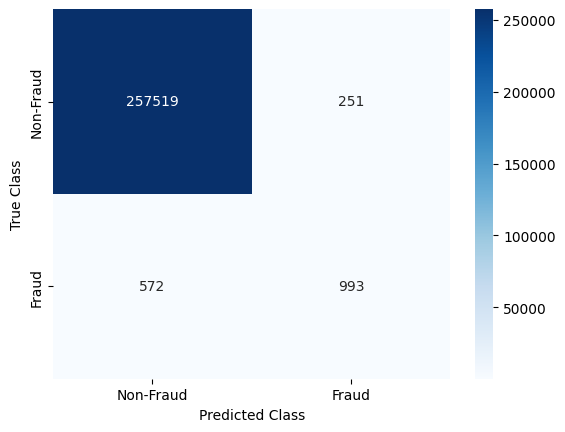

In [25]:
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

The tuned model is better with non-fraud data, worse with fraud data, we should adjust tuning in future analysis to improve true positive rate